In [1]:
#dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import time
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, cast, Date, desc
from scipy.stats import sem, ttest_ind

In [2]:
#set path of sqlite file
db_path = 'data/hawaii.sqlite'
#create connection engine variable 
engine = create_engine(f'sqlite:///{db_path}')


In [3]:
#get the ability to pull the schema from sqlite file
Base = automap_base()
Base.prepare(engine, reflect=True)
inspector = inspect(engine)
session = Session(engine) #connect to sqlite db
conn = engine.connect

In [4]:
#pull list of tables
Base.classes.keys()

['measurement', 'station']

In [5]:
Station = Base.classes.station
Measurement = Base.classes.measurement


In [6]:
measurement_columns = inspector.get_columns('measurement')
for x in measurement_columns:
    print (x['name'], x['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
station_columns = inspector.get_columns('station')
for x in station_columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis


In [8]:
date_range = session.query(*[func.max(Measurement.date)]).all() #query to find latest date in dataset
df_date_range = pd.DataFrame(date_range, columns=['date']) #put result into a df
df_date_range

,date
0,2017-08-23


In [9]:
max_date = df_date_range.max()['date']
dt_max_date = dt.datetime.strptime(max_date, '%Y-%m-%d') #get latest date in dataset into datetime object
dt_year_before = dt_max_date + dt.timedelta(days=-365)
dt_year_before

datetime.datetime(2016, 8, 23, 0, 0)

In [10]:
#get one year prior to the latest date in dataset in yyyy-mm-dd format
year_before = dt.date.strftime(dt_year_before, '%Y-%m-%d') 
year_before

'2016-08-23'

In [11]:
precipitation_sel = [Measurement.prcp, Measurement.date] #select amount of precipitation and date from database
#query date and precipitation for the last year of our dataset
precipitation = session.query(*precipitation_sel).filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_before).\
    order_by(Measurement.date).all()
df_prec = pd.DataFrame(precipitation, columns=['Precipitation', 'date']) #put results of query into a df
df_prec = df_prec.set_index('date') #set date column as the index
df_prec.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


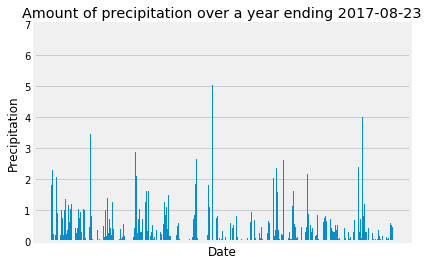

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
df_prec_mean = df_prec.groupby('date').max()
x_axis = np.arange(len(df_prec_mean))
plt.bar(x_axis, df_prec_mean['Precipitation'])
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title(f'Amount of precipitation over a year ending {max_date}')
plt.xticks(ticks=[])
plt.savefig('images/precipitation_last_year.jpg')
plt.show()

In [13]:
#count the number of stations
sel_station_count = [func.count(Station.id)]
session.query(*sel_station_count).all()

[(9)]

In [14]:
#find the most active stations
sel_station_activity = [Measurement.station, func.count(Measurement.station)]
session.query(*sel_station_activity).group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#find station id of station with most activity
station_most_active = session.query(*[Measurement.station]).group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).limit(1).all()
station_most_active = station_most_active[0][0]

In [16]:
station_most_active

'USC00519281'

In [17]:
#for the station with most activity:
#find the lowest temp, the highest temp, and average temp recorded
temp_stats_sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*temp_stats_sel).filter(Measurement.station == station_most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
#query last 12 months of tempeture data recorded by most active station
temp_sel = [Measurement.date, Measurement.tobs]
temps = session.query(*temp_sel).filter(Measurement.station == station_most_active).\
    filter(Measurement.date > year_before)

Text(0.5, 1.0, 'Frequency of observed tempetures for the year beginning 2016-08-23 observed by Weather Station USC00519281')

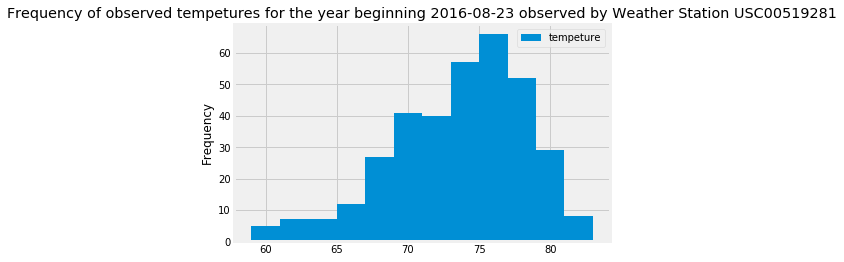

In [19]:
#plot 12 months of tempeture data recorded by most active station
df_temps = pd.DataFrame(temps, columns=['date', 'tempeture'])
df_temps = df_temps.set_index('date')
ax = df_temps.plot.hist(bins=12)
ax.set_title(f'Frequency of observed tempetures for the year beginning {year_before} observed by Weather Station {station_most_active}')

# Tempeture analysis 1

In [20]:
#find average June Tempeture for all stations
june_sel = [func.avg(Measurement.tobs), Measurement.station]
june_ = session.query(*june_sel).filter(func.strftime('%m', Measurement.date) == '06').\
    group_by(Measurement.station).all()
june = [] #cretae empty list to store June avergae tempetures
#for loop to extract only average tempetures for June, and add each average temp to list
for x, y in june_:
    june.append(x)


In [21]:
#find average December Tempeture for all stations
dec_sel = [func.avg(Measurement.tobs), Measurement.station]
dec_ = session.query(*dec_sel).filter(func.strftime('%m', Measurement.date) == '12').\
    group_by(Measurement.station).all()
december = [] #cretae empty list to store December avergae tempetures
#for loop to extract only average tempetures for December, and add each average temp to list
for x, y in dec_:
    december.append(x)


In [22]:
#run a t-test to see if the average temps in June are the same as the average temps in Dec
__, p = ttest_ind(june, december, equal_var=False)
p
#the null hypothesis is the two temps are the same
#the P-value is under 0.05, and as such we reject the null hypothesis, and accept that the 
    #two temps are different

0.0003657335214469917

# Tempeture Analysis 2

In [23]:
#find the min, average and max tempeture from the previous year for the dates of a 
#hypothetical trip
#Trip dates - July 1, 2018 to July 8, 2018

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [25]:
trip = calc_temps('2017-07-01', '2017-07-08')
trip

[(71.0, 78.04347826086956, 87.0)]

# Rainfall during trip

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [27]:
#Trip dates - July 1, 2018 to July 8, 2018
#create list of trip dates
trip_date = ['07-01', '07-02', '07-03', '07-04', '07-05', '07-06', '07-07', '07-08']

In [28]:
#create empty lists of the minimum, average and maximum rain amounts for trip
rain_min = []
rain_max = []
rain_avg = []
#for loop to run the daily normals function through all trip dates, and append to list
for x in trip_date:
    result = daily_normals(x)
    #append the results to lists of minimum, maximum, and average lists
    for minn, avg, maxx in result:
        rain_min.append(minn)
        rain_max.append(maxx)
        rain_avg.append(avg)


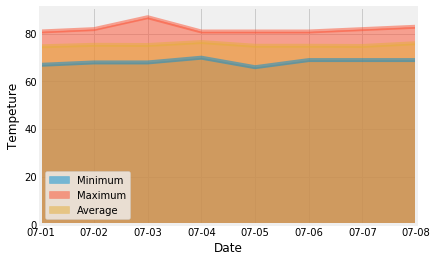

In [29]:
#create dictionary to put in DF
rain_dict = {'Date':trip_date, 'Minimum':rain_min, 'Maximum':rain_max, 'Average': rain_avg}
#df of dates, min, max, and average rain totals for trip
rain = pd.DataFrame(rain_dict)
#set the index to the Date columns
rain = rain.set_index('Date')

#create area plot of min, max and average temps of temps during trip
rain.plot.area(stacked=False)
plt.ylabel('Tempeture')
plt.show()